<a href="https://colab.research.google.com/github/jenyotoluwalope/Enzyme_Evo/blob/main/model_for_methane_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Methane Neutralized (g)            330.00
Nitrate Needed (g)                1019.70
Acetate Energy Gained (g)          607.20
Climate Impact (kg CO2e saved)       9.24
dtype: float64


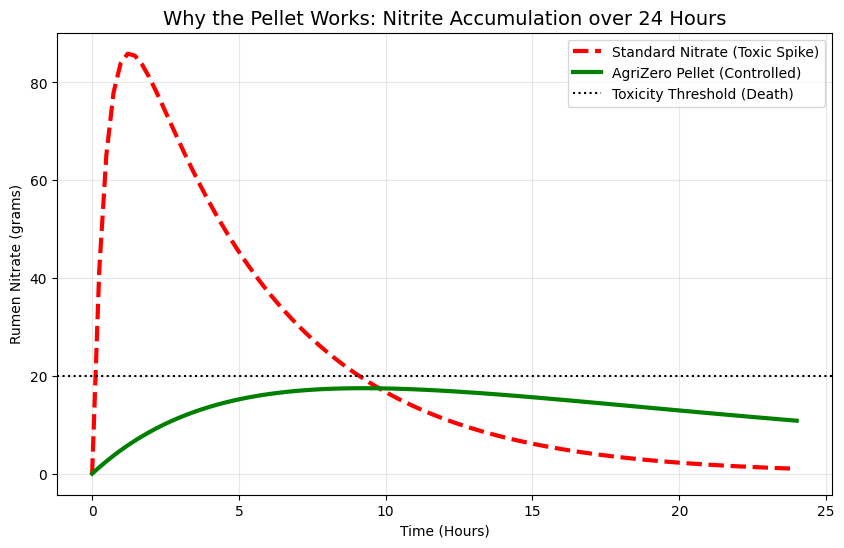

--- Daily Profit Per Cow ---
Nitrate Dosed: 150.0 g
Acetate Produced: 89.32 g
Extra Energy for Cow: 312.62 kcal
Energy Boost: +1.04% of daily needs
--- THE TRADE-OFF TABLE ---
|   Release Rate (k) |   Peak Nitrate (g) | Safety Status   |   Effective Boost (%) |
|-------------------:|-------------------:|:----------------|----------------------:|
|               0.05 |              17.48 | RISKY           |                  0.74 |
|               0.04 |              14.85 | RISKY           |                  0.69 |
|               0.03 |              11.91 | RISKY           |                  0.61 |
|               0.02 |               8.59 | SAFE            |                  0.51 |
|               0.01 |               4.74 | SAFE            |                  0.34 |
---OPTIMIZING FOR GEOMETRY & DENSITY (Fixed Release k=0.02)---
| Device Type   |   Retention Hours |   Waste (%) |   Effective Boost (%) |
|:--------------|------------------:|------------:|----------------------:|
| Light

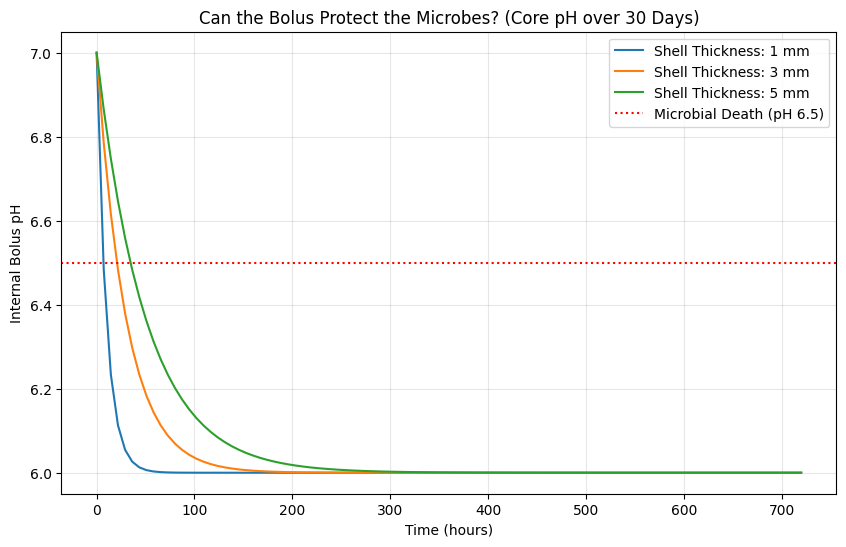

In [18]:
!pip install cobra python-libsbml pandas matplotlib
import pandas as pd
def calculate_agrizero_balance(methane_grams):
  nitrate_per_methane = 3.09
  acetate_per_methane = 1.84
  nitrate_needed = methane_grams * nitrate_per_methane
  acetate_produced = methane_grams * acetate_per_methane
  co2_eq_saved = methane_grams * 28/1000
  return {
      "Methane Neutralized (g)": methane_grams,
      "Nitrate Needed (g)": round(nitrate_needed, 2),
      "Acetate Energy Gained (g)": round(acetate_produced, 2),
      "Climate Impact (kg CO2e saved)": round(co2_eq_saved, 2)

  }
cow_data = calculate_agrizero_balance(330)
print(pd.Series(cow_data))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
k_release_fast = 2.0
k_release_slow = 0.05
k_clearance = 0.2
nitrate_dose = 150.0

def rumen_kinetic(y, t, k_release):
  Nitrate_Pellet, Nitrate_Rumen = y
  d_Nitrate_Pellet_dt = -k_release * Nitrate_Pellet
  d_Nitrate_Rumen_dt = (k_release * Nitrate_Pellet * 0.74) - (k_clearance * Nitrate_Rumen)
  return [d_Nitrate_Pellet_dt, d_Nitrate_Rumen_dt]

t = np.linspace(0, 24, 100)
y0 = [nitrate_dose, 0.0]

sol_fast = odeint(rumen_kinetic, y0, t, args=(k_release_fast,))
nitrate_rumen_fast = sol_fast[:, 1]

sol_slow = odeint(rumen_kinetic, y0, t, args=(k_release_slow,))
nitrate_rumen_slow = sol_slow[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(t, nitrate_rumen_fast, 'r--', label='Standard Nitrate (Toxic Spike)', linewidth=3)
plt.plot(t, nitrate_rumen_slow, 'g-', label='AgriZero Pellet (Controlled)', linewidth=3)
plt.axhline(y=20, color='black', linestyle=':', label='Toxicity Threshold (Death)')
plt.title('Why the Pellet Works: Nitrite Accumulation over 24 Hours', fontsize=14)
plt.xlabel('Time (Hours)')
plt.ylabel('Rumen Nitrate (grams)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
def calculate_acetate_profit(nitrate_consumed_grams):
  acetate_yield_ratio = 1.84/3.09
  total_acetate = nitrate_consumed_grams * acetate_yield_ratio
  total_energy_kcal = total_acetate * 3.5
  return total_acetate, total_energy_kcal

acetate_g, total_energy_kcal = calculate_acetate_profit(150)
print(f"--- Daily Profit Per Cow ---")
print(f"Nitrate Dosed: 150.0 g")
print(f"Acetate Produced: {acetate_g:.2f} g")
print(f"Extra Energy for Cow: {total_energy_kcal:.2f} kcal")
boost_percent = (total_energy_kcal/30000) * 100
print(f"Energy Boost: +{boost_percent:.2f}% of daily needs")
results = []
test_k_values = [0.05, 0.04, 0.03, 0.02, 0.01]
k_passage = 1/48
for k in test_k_values:
  sol = odeint(rumen_kinetic, y0, t, args=(k,))
  peak_nitrate = max(sol[:, 1])
  efficiency = k/(k + k_passage)
  effective_dose = nitrate_dose * efficiency
  acetate_g_loop, total_energy_kcal_loop = calculate_acetate_profit(effective_dose)
  results.append({
      "Release Rate (k)": k,
      "Peak Nitrate (g)": round(peak_nitrate, 2),
      "Safety Status": "DEADLY" if peak_nitrate > 20 else ("RISKY" if peak_nitrate > 10 else "SAFE"),
      "Effective Boost (%)": round((total_energy_kcal_loop/30000) * 100, 2)
  })
import pandas as pd
df_results = pd.DataFrame(results)
print("--- THE TRADE-OFF TABLE ---")
print(df_results.to_markdown(index=False))
result_retained = []
k_safe = 0.02
retention_scenarios = [
    {"type": "Light Pellet", "hours": 48},
    {"type": "Medium Pellet", "hours": 150},
    {"type": "Heavy Pellet", "hours": 2000},
    {"type": "Winged Device", "hours":5000}
]
print(f"---OPTIMIZING FOR GEOMETRY & DENSITY (Fixed Release k={k_safe})---")
for scenario in retention_scenarios:
  k_passage_new = 1/scenario["hours"]
  efficiency = k_safe/(k_safe + k_passage_new)
  effective_dose = nitrate_dose * efficiency
  acetate, energy = calculate_acetate_profit(effective_dose)
  boost_percent = (energy/30000) * 100
  result_retained.append({
      "Device Type": scenario["type"],
      "Retention Hours": scenario["hours"],
      "Waste (%)": round((1 - efficiency) * 100, 1),
      "Effective Boost (%)": round(boost_percent, 2)
  })
df_results_retained = pd.DataFrame(result_retained)
print(df_results_retained.to_markdown(index=False))
import numpy as np
import matplotlib.pyplot as plt
def simulate_ph_protection(shell_thickness_mm):
  D_effective = 1e-5
  time_hours = np.linspace(0, 720, 100)
  k_acid_intrusion = 0.1/shell_thickness_mm
  ph_core = 6.0 + (7.0 - 6.0) * np.exp(-k_acid_intrusion * time_hours)
  return time_hours, ph_core

thickness = [1, 3, 5]
plt.figure(figsize=(10, 6))
for t in thickness:
  time, ph_levels = simulate_ph_protection(t)
  plt.plot(time, ph_levels, label=f'Shell Thickness: {t} mm')
plt.axhline(y=6.5, color='red', linestyle=':', label='Microbial Death (pH 6.5)')
plt.title('Can the Bolus Protect the Microbes? (Core pH over 30 Days)')
plt.xlabel('Time (hours)')
plt.ylabel('Internal Bolus pH')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()